In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from langdetect import detect # language detection
import numpy as np # linear algebra
import tqdm # progress bar
import re # regular expressions
import pickle as pkl # saving and loading pythonic data

## Import custom libraries

In [2]:
import sys, os # system specific parameters and functions
sys.path.append(os.getcwd() + "/../") # add parent directory to path
from src.data_preprocessing import DataPreprocessing

## Load the data

In [3]:
dp = DataPreprocessing(df_path="../data/real_estate_ads_2022_10.csv", 
                       train_indices_path="../data/train_indices.npy", 
                       test_indices_path="../data/test_indices.npy")

In [4]:
dp.X.columns

Index(['market', 'created_at_first', 'updated_at', 'district_lon',
       'district_lat', 'title', 'description', 'params', 'no_rooms', 'm',
       'map_lon', 'map_lat'],
      dtype='object')

## Load TFIDF embeddings

In [6]:
with open("../data/tfidf_vectorizer_title.pkl", "rb") as f:
    tfidf_vectorizer_descriptions = pkl.load(f)

with open("../data/tfidf_vectorizer_description.pkl", "rb") as f:
    tfidf_vectorizer_descriptions = pkl.load(f)

tfidf_titles_embeddings = tfidf_vectorizer_titles.transform(dp.X["title"].apply(lambda x: np.str_(x)))
tfidf_descriptions_embeddings = tfidf_vectorizer_descriptions.transform(dp.X["description"].apply(lambda x: np.str_(x)))

## Load Polish BERT embeddings
***ONLY FOR TITLE**. For the rest, they were too computationally expensive

In [11]:
import torch 

bert_embeddings_paths = os.listdir("../data/bert_embeddings")
title_embeddings_paths = [b for b in bert_embeddings_paths if "title_embeddings_batch_size_1000" in b]

In [13]:
total_embeddings = []

for path in title_embeddings_paths:
    total_embeddings.append(torch.load("../data/bert_embeddings/" + path))
bert_title_embeddings = torch.cat(total_embeddings).numpy()
bert_title_embeddings.shape

(73645, 768)

### Do some visualizations

In [44]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def plot_projection_embeddings(embeddings,
                                prices_per_m, scale=True, projection_method="PCA",
                                title="",
                                explained_variance=True):
    
    #prices_per_m_scaler = MinMaxScaler()
    #prices_per_m = prices_per_m_scaler.fit_transform(prices_per_m.to_numpy().reshape(-1, 1))

    prices_per_m = prices_per_m.clip(lower=-5, upper=5)

    if scale:
        try:
            scaler = StandardScaler()
            embeddings = scaler.fit_transform(embeddings)
        except:
            scaler = StandardScaler(with_mean=False)
            embeddings = scaler.fit_transform(embeddings) # for sparse matrices

    if projection_method == "PCA":
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(embeddings)

    elif projection_method == "TSNE":
        tsne = TSNE(n_components=2, init="random")
        principal_components = tsne.fit_transform(embeddings)

    fig,ax = plt.subplots()
    scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], c=prices_per_m, cmap='viridis',
                            s=10, alpha=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

    if projection_method == "PCA" and explained_variance:

        pca_dummy = PCA(n_components=int(embeddings.shape[1] / 2))
        pca_dummy.fit(embeddings)
        cumulative_variance_ratio = np.cumsum(pca_dummy.explained_variance_ratio_)
        plt.plot(cumulative_variance_ratio, marker="o")
        plt.xlabel("Number of components")
        plt.ylabel("Cumulative explained variance")
        plt.title("PCA cumulative explained variance")
        plt.show()


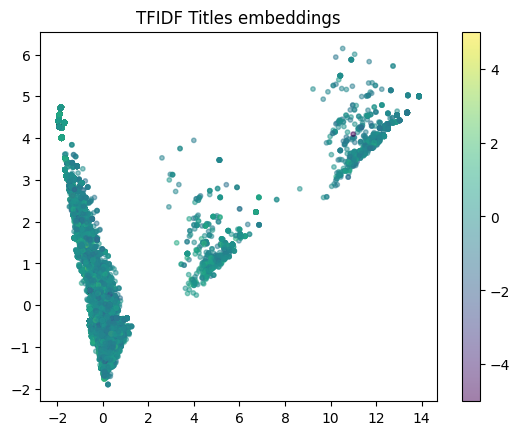

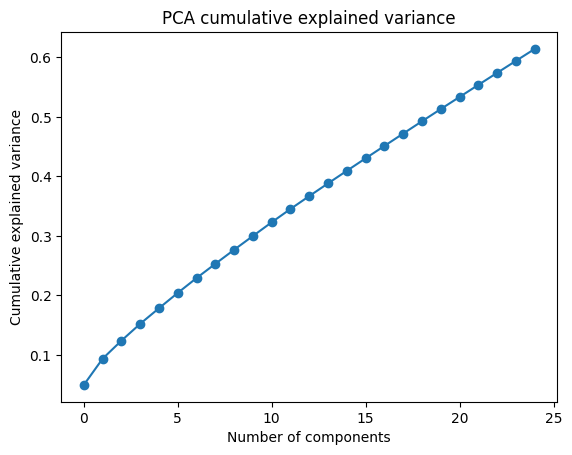

In [45]:
plot_projection_embeddings(tfidf_titles_embeddings, dp.Y["standard_cbrt_price_per_m"], title="TFIDF Titles embeddings")

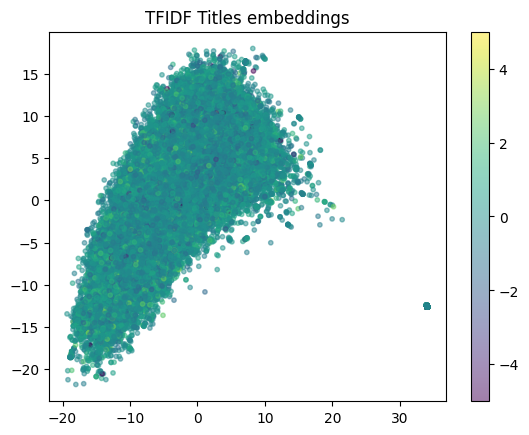

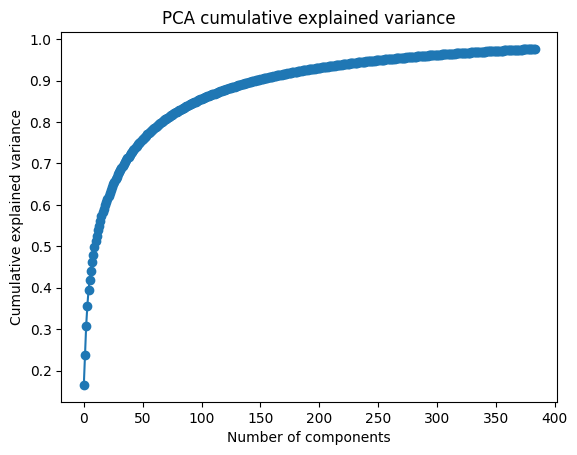

In [48]:
plot_projection_embeddings(bert_title_embeddings, dp.Y["standard_cbrt_price_per_m"], title="TFIDF Titles embeddings")

## Get PCA features
### For TFIDF titles

In [64]:
pca = PCA(n_components=5)
tfidf_titles_embeddings_train = tfidf_titles_embeddings[dp.train_indices]
tfidf_titles_embeddings_train_pca = pca.fit(tfidf_titles_embeddings_train)
pca_tfidf_titles = pca.transform(tfidf_titles_embeddings)
pca_tfidf_titles.shape

df = pd.DataFrame(pca_tfidf_titles)
df.columns = ["pca_tfidf_titles_" + str(i) for i in range(pca_tfidf_titles.shape[1])]
df.to_csv("../data/new_features/pca_tfidf_titles.csv", index=False)
df

,pca_tfidf_titles_0,pca_tfidf_titles_1,pca_tfidf_titles_2,pca_tfidf_titles_3,pca_tfidf_titles_4
0,0.754213,0.080996,0.275464,-0.272315,0.046350
1,-0.104753,-0.014137,-0.127719,-0.033529,-0.039475
2,-0.213654,-0.223346,0.126592,0.010555,-0.000420
3,0.373167,0.060242,-0.040348,0.344978,0.042251
4,-0.236854,-0.281298,0.221511,0.030972,0.015520
...,...,...,...,...,...
73640,-0.103183,-0.042828,-0.129010,-0.071618,-0.049766
73641,-0.059647,-0.049302,-0.184401,0.233408,0.012658
73642,-0.247863,-0.287329,0.240454,0.043654,0.018859
73643,-0.180689,-0.014721,-0.421428,-0.215023,0.790832


### For TFIDF descriptions

In [63]:
pca = PCA(n_components=5)
tfidf_descriptions_embeddings_train = tfidf_descriptions_embeddings[dp.train_indices]
tfidf_descriptions_embeddings_train_pca = pca.fit(tfidf_descriptions_embeddings_train)
pca_tfidf_descriptions = pca.transform(tfidf_descriptions_embeddings)

df = pd.DataFrame(pca_tfidf_descriptions)
df.columns = ["pca_tfidf_descriptions_" + str(i) for i in range(pca_tfidf_descriptions.shape[1])]
df.to_csv("../data/new_features/pca_tfidf_descriptions.csv", index=False)
df

,pca_tfidf_descriptions_0,pca_tfidf_descriptions_1,pca_tfidf_descriptions_2,pca_tfidf_descriptions_3,pca_tfidf_descriptions_4
0,0.429711,-0.085166,0.074412,-0.063673,-0.149363
1,0.013299,-0.193857,-0.565434,-0.087247,-0.225203
2,0.487830,0.024672,0.317637,0.085468,0.194455
3,0.440204,-0.051430,0.085958,-0.065707,0.143295
4,0.113410,-0.211962,-0.340705,-0.068037,-0.262050
...,...,...,...,...,...
73640,-0.383243,0.387560,-0.275452,-0.111615,-0.069160
73641,0.526012,-0.021013,0.195143,-0.006690,-0.103451
73642,0.284675,-0.077442,-0.088250,-0.012326,0.047845
73643,0.441381,-0.053417,0.085477,-0.052418,-0.021937


### For BERT embeddings titles

In [65]:
pca = PCA(n_components=5)
bert_title_embeddings_train = bert_title_embeddings[dp.train_indices]
bert_title_embeddings_train_pca = pca.fit(bert_title_embeddings_train)
pca_bert_titles = pca.transform(bert_title_embeddings)

df = pd.DataFrame(pca_bert_titles)
df.columns = ["pca_bert_titles_" + str(i) for i in range(pca_bert_titles.shape[1])]
df.to_csv("../data/new_features/pca_bert_titles.csv", index=False)
df

,pca_bert_titles_0,pca_bert_titles_1,pca_bert_titles_2,pca_bert_titles_3,pca_bert_titles_4
0,-1.673384,-2.092606,-3.349455,0.676381,-0.215404
1,-5.718431,0.623590,-1.628233,3.893912,0.762644
2,2.064359,2.595388,0.156635,3.524757,0.243423
3,0.871504,-0.695551,-1.974088,0.230872,-3.593429
4,0.180490,-1.311857,1.389151,-1.126016,3.231045
...,...,...,...,...,...
73640,2.757562,0.334386,0.396651,-2.210193,0.322360
73641,-13.029988,-0.273106,4.918483,-0.024143,-0.883491
73642,-1.909320,0.538410,-1.807861,-0.404571,1.351976
73643,-0.589373,1.975970,-1.575956,3.406204,2.013482


## Use partial least squares projection

In [81]:
from sklearn.cross_decomposition import PLSRegression

X_train, X_test = dp.get_train_test_split(dp.X)
y_train, y_test = dp.get_train_test_split(dp.Y)

In [83]:
pls2 = PLSRegression(n_components=2)
tfidf_titles_embeddings_train = tfidf_titles_embeddings[dp.train_indices]
tfidf_titles_embeddings_train_pld2 = pls2.fit(tfidf_titles_embeddings_train.toarray(), y_train)

tfidf_titles_embeddings_pls2 = pls2.transform(tfidf_titles_embeddings.toarray())

df = pd.DataFrame(tfidf_titles_embeddings_pls2)
df.columns = ["pls2_tfidf_titles_" + str(i) for i in range(tfidf_titles_embeddings_pls2.shape[1])]
df.to_csv("../data/new_features/pls2_tfidf_titles.csv", index=False)
df

,pls2_tfidf_titles_0,pls2_tfidf_titles_1
0,-0.342587,0.795182
1,-0.895393,0.588137
2,-1.080821,0.518425
3,-0.423726,2.929119
4,-0.394299,-0.177271
...,...,...
73640,-0.655452,-0.293617
73641,-0.439299,0.719215
73642,-1.443489,0.334559
73643,1.284712,-2.117068


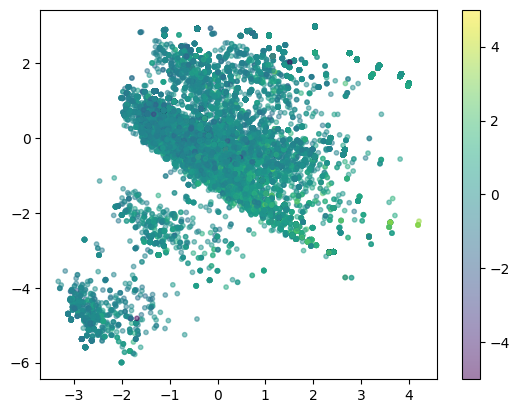

In [92]:
fig, ax = plt.subplots()
scatter = ax.scatter(tfidf_titles_embeddings_pls2[:, 0], tfidf_titles_embeddings_pls2[:, 1], 
                        c=dp.Y["standard_cbrt_price_per_m"].clip(lower=-5,upper=5), cmap='viridis',
                        s=10, alpha=0.5)
plt.colorbar(scatter)
plt.show()

### For descriptions

In [93]:
pls2 = PLSRegression(n_components=2)
tfidf_description_embeddings_train = tfidf_descriptions_embeddings[dp.train_indices]
tfidf_description_embeddings_train_pld2 = pls2.fit(tfidf_description_embeddings_train.toarray(), y_train)

tfidf_description_embeddings_pls2 = pls2.transform(tfidf_descriptions_embeddings.toarray())


df = pd.DataFrame(tfidf_description_embeddings_pls2)
df.columns = ["pls2_tfidf_descriptions_" + str(i) for i in range(tfidf_description_embeddings_pls2.shape[1])]
df.to_csv("../data/new_features/pls2_tfidf_descriptions.csv", index=False)
df

,pls2_tfidf_descriptions_0,pls2_tfidf_descriptions_1
0,1.918531,1.164422
1,7.310610,0.523674
2,-0.956301,-0.138823
3,0.651467,-1.790728
4,3.990684,3.670849
...,...,...
73640,0.658381,-1.043047
73641,2.795226,-0.427009
73642,2.594562,-1.839871
73643,1.020083,-0.322440


### For BERT embeddings of the titles

In [94]:
pls2 = PLSRegression(n_components=2)
bert_title_embeddings_train = bert_title_embeddings[dp.train_indices]
bert_title_embeddings_train_pld2 = pls2.fit(bert_title_embeddings_train, y_train)

bert_title_embeddings_pls2 = pls2.transform(bert_title_embeddings)

df = pd.DataFrame(bert_title_embeddings_pls2)
df.columns = ["pls2_bert_titles_" + str(i) for i in range(bert_title_embeddings_pls2.shape[1])]
df.to_csv("../data/new_features/pls2_bert_titles.csv", index=False)
df

,pls2_bert_titles_0,pls2_bert_titles_1
0,-5.625072,1.667885
1,-9.117264,-7.874629
2,2.538720,2.865016
3,0.929967,0.089860
4,1.583019,2.069715
...,...,...
73640,3.135009,5.928662
73641,-12.736843,-19.435305
73642,-6.590075,3.400506
73643,-5.502053,4.537917
